In [93]:
import cox
from cox.readers import CollectionReader
import os 
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# set environment variable so that stores can create output files
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'
ROOT = '/home/gridsan/stefanou/'
EXP = 'step_lr_noised_weight_decay'
# constants 
BASE_CLASSIFIER = '/base_classifier/'
LOGIT_BALL_CLASSIFIER = '/logit_ball/'
STANDARD_CLASSIFIER = '/standard_classifier/'

In [187]:
def plot(logs, metadata, class_): 
    # iterate over learning rates
    for i, lr in enumerate(np.sort(metadata.lr.unique())): 
        # extract meta logs of interest 
        meta_logs = metadata[(metadata.lr == lr)]        
        
        fig, ax = plt.subplots(2, 2, figsize=(10, 7.5), constrained_layout=True)
        for j, weight_decay in enumerate(meta_logs.weight_decay.unique()):
            lr_logs = logs[logs.exp_id.isin(meta_logs[meta_logs.weight_decay == weight_decay].exp_id)]
                        
            if len(lr_logs) == 0: 
                continue
            # plot loss curves
            ax[0, 0].plot(lr_logs.epoch, lr_logs.train_loss, label='{} weight decay'.format(weight_decay))
            ax[1, 0].plot(lr_logs.epoch, lr_logs.val_loss, label='{} weight decay'.format(weight_decay))
            
            # plot accuracy curves
            ax[0, 1].plot(lr_logs.epoch, lr_logs.train_prec1, label='{} weight decay'.format(weight_decay))
            ax[1, 1].plot(lr_logs.epoch, lr_logs.val_prec1, label='{} weight decay'.format(weight_decay))
            
        ax[0, 0].set_title('{} Train Loss: lr - {}'.format(class_, lr))
        ax[0, 0].set_xlabel('Epoch')
        ax[0, 0].set_ylabel('CE Loss')
        ax[1, 0].set_title('{} Validation Loss: lr - {}'.format(class_, lr))
        ax[1, 0].set_xlabel('Epoch')
        ax[1, 0].set_ylabel('CE Loss')
        ax[0, 0].legend()
        ax[1, 0].legend()
        ax[0, 1].set_title('{} Accuracy: lr - {}'.format(class_, lr))
        ax[0, 1].set_xlabel('Epoch')
        ax[0, 1].set_ylabel('Accuracy')
        ax[1, 1].set_title('{} Val Accuray: lr - {}'.format(class_, lr))
        ax[1, 1].set_xlabel('Epoch')
        ax[1, 1].set_ylabel('Accuracy')
        ax[0, 1].legend()
        ax[1, 1].legend()
        plt.show()

In [94]:
base_reader = CollectionReader(ROOT + EXP + BASE_CLASSIFIER)
base_logs = base_reader.df('logs')
base_metadata = base_reader.df('metadata')
unseen = base_reader.df('unseen')
test = base_reader.df('test')
trunc_train = base_reader.df('trunc_train')
train_base = base_reader.df('train_base')
base_reader.close()

trunc_reader = CollectionReader(ROOT + EXP + LOGIT_BALL_CLASSIFIER)
trunc_logs = trunc_reader.df('logs')
trunc_metadata = trunc_reader.df('metadata')
trunc_unseen = trunc_reader.df('unseen')
trunc_test = trunc_reader.df('test')
trunc_trunc_train = trunc_reader.df('trunc_train')
trunc_train_base = trunc_reader.df('train_base')
trunc_reader.close()

standard_reader = CollectionReader(ROOT + EXP + STANDARD_CLASSIFIER)
standard_logs = standard_reader.df('logs')
standard_metadata = standard_reader.df('metadata')
standard_unseen = standard_reader.df('unseen')
standard_test = standard_reader.df('test')
standard_trunc_train = standard_reader.df('trunc_train')
standard_train_base = standard_reader.df('train_base')
standard_reader.close()

100%|██████████| 54/54 [00:30<00:00,  1.79it/s]


new schema missing keys: set(), new keys: {'device', 'accuracy'}
new schema missing keys: set(), new keys: {'device', 'accuracy'}
new schema missing keys: set(), new keys: {'device', 'accuracy'}
new schema missing keys: set(), new keys: {'device', 'accuracy'}
new schema missing keys: set(), new keys: {'device', 'accuracy'}
new schema missing keys: set(), new keys: {'device', 'accuracy'}
new schema missing keys: set(), new keys: {'device', 'accuracy'}
new schema missing keys: set(), new keys: {'device', 'accuracy'}
new schema missing keys: set(), new keys: {'device', 'accuracy'}
new schema missing keys: set(), new keys: {'device', 'accuracy'}
new schema missing keys: set(), new keys: {'device', 'accuracy'}
new schema missing keys: set(), new keys: {'device', 'accuracy'}
new schema missing keys: set(), new keys: {'device', 'accuracy'}
new schema missing keys: set(), new keys: {'device', 'accuracy'}
new schema missing keys: set(), new keys: {'device', 'accuracy'}
new schema missing keys: 

100%|██████████| 18/18 [00:01<00:00, 11.30it/s]


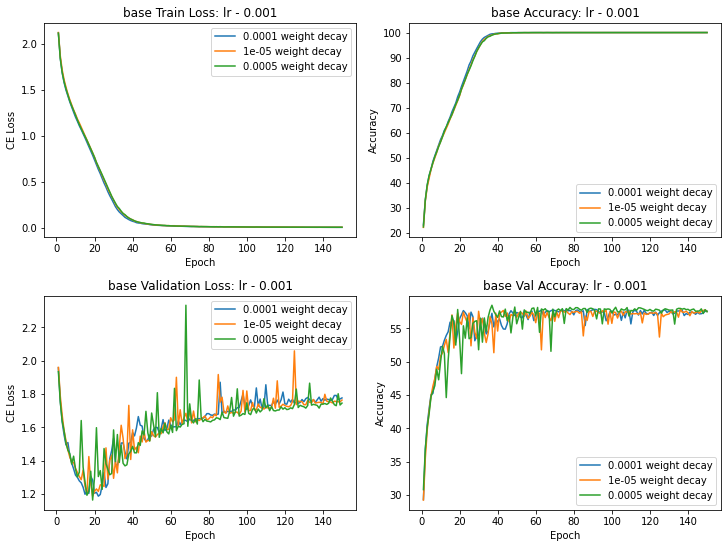

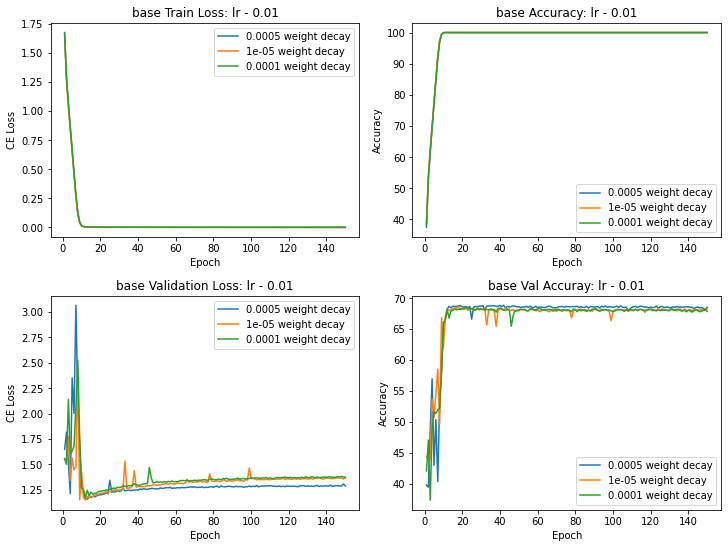

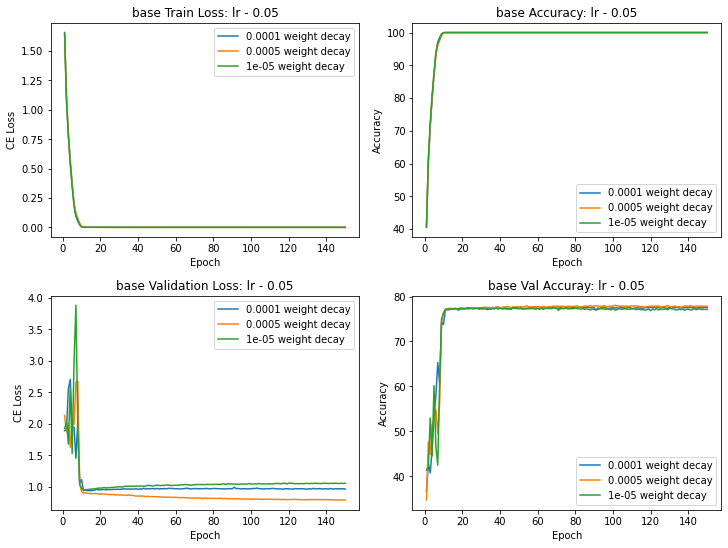

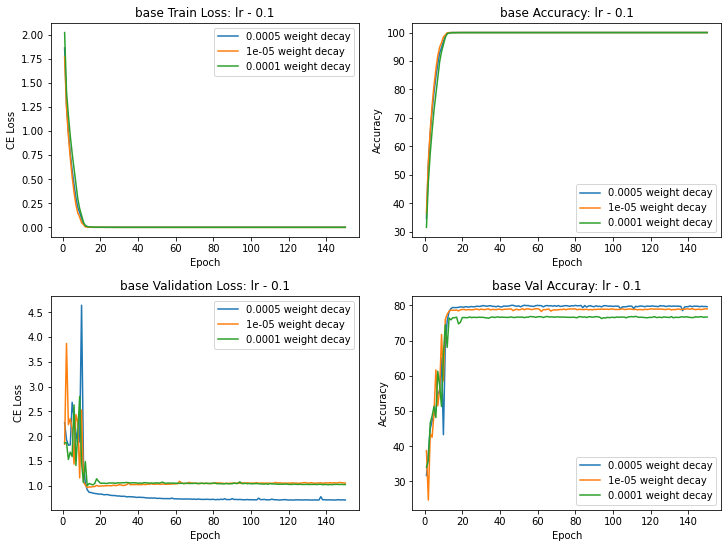

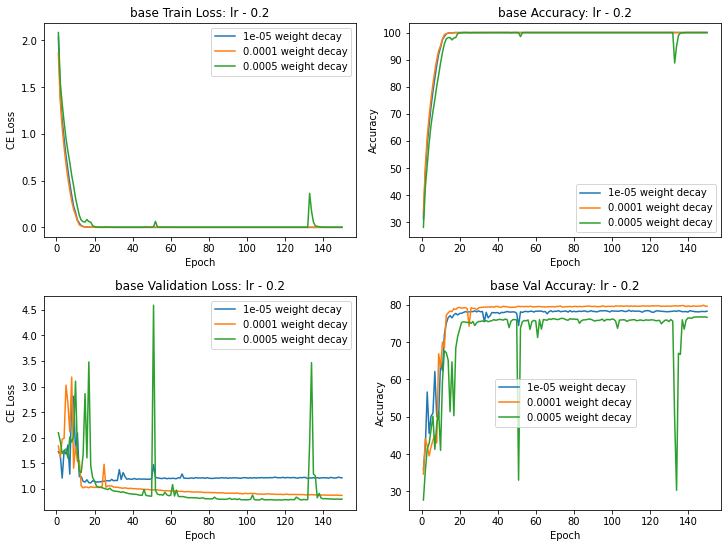

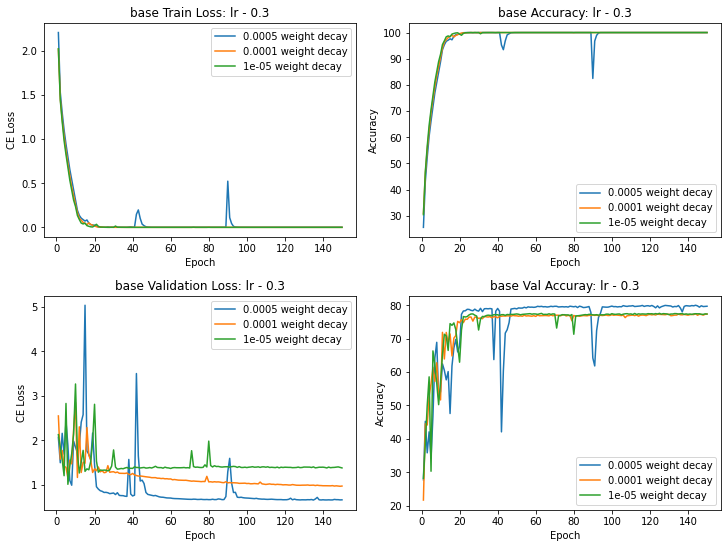

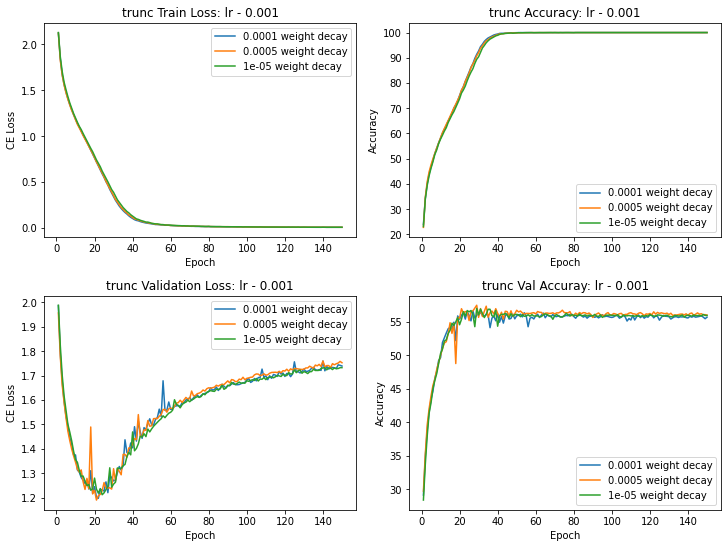

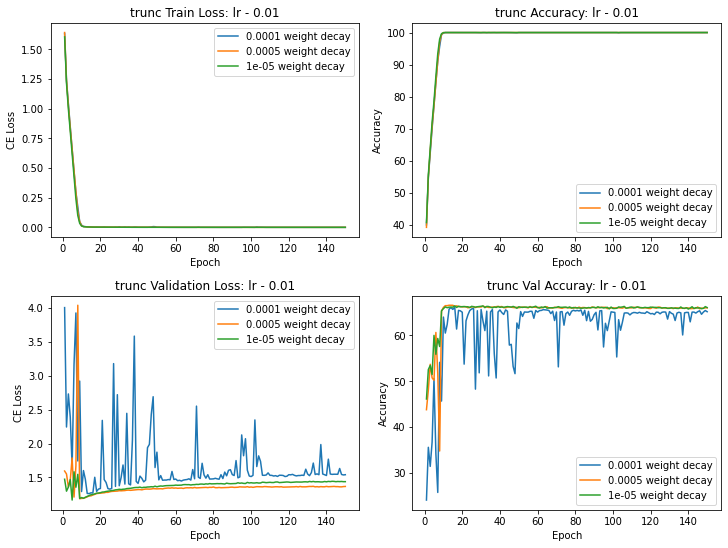

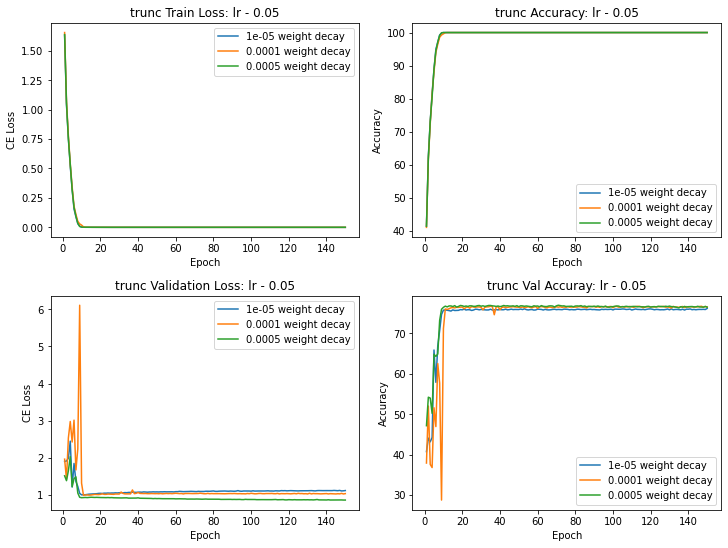

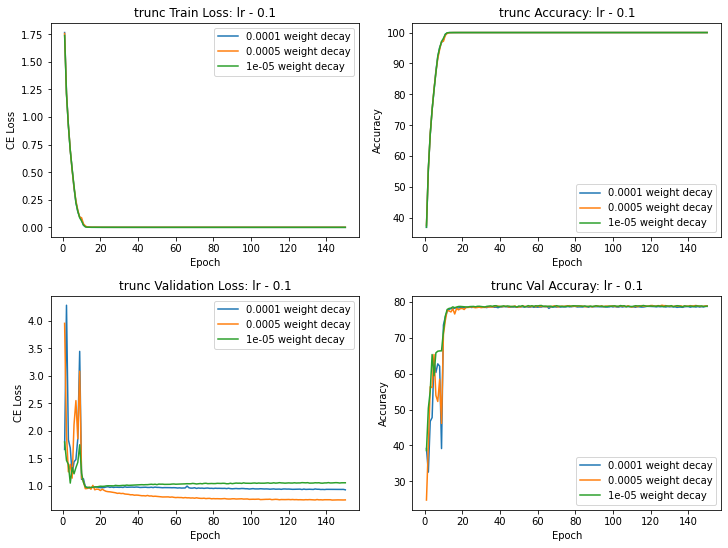

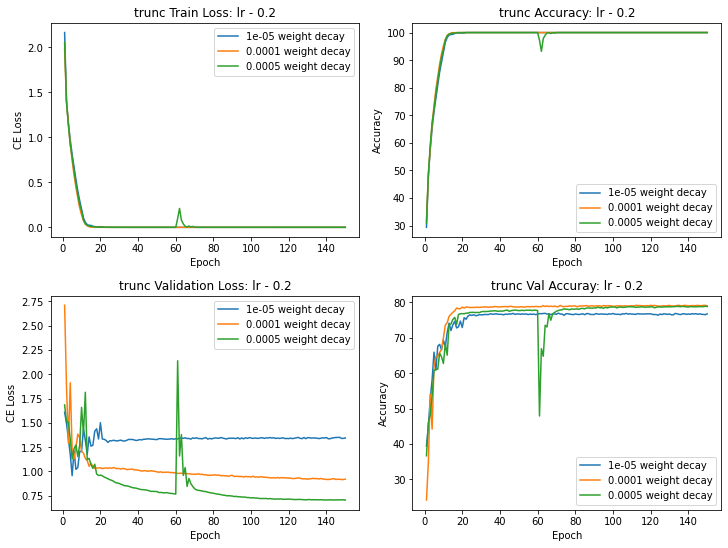

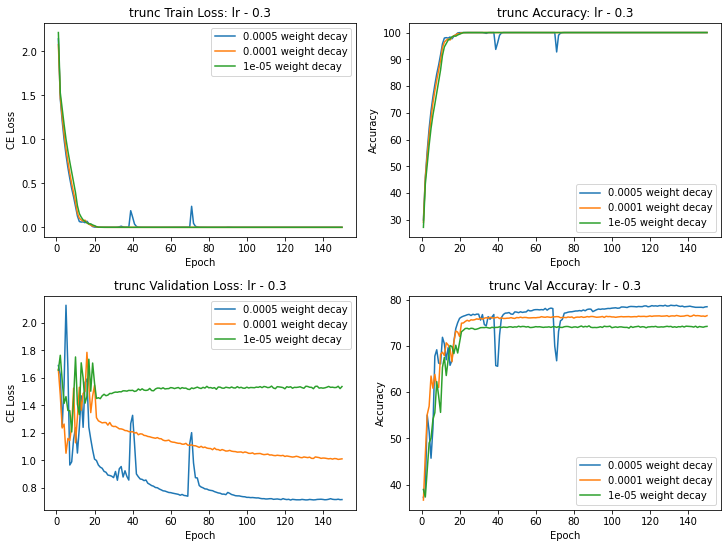

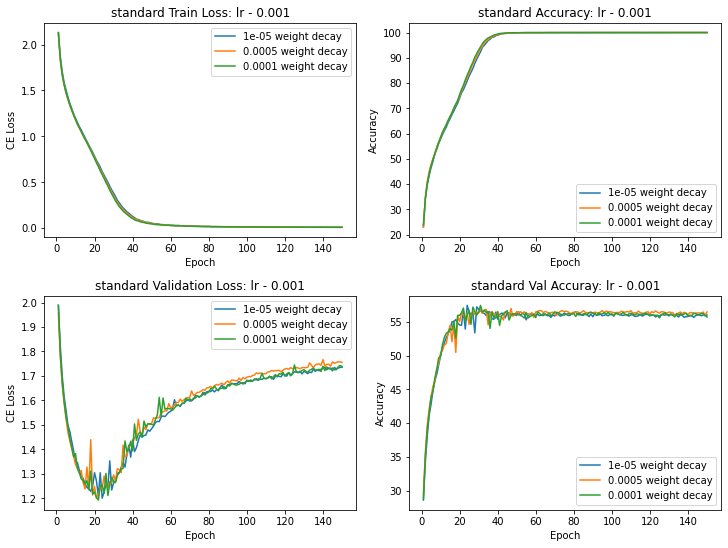

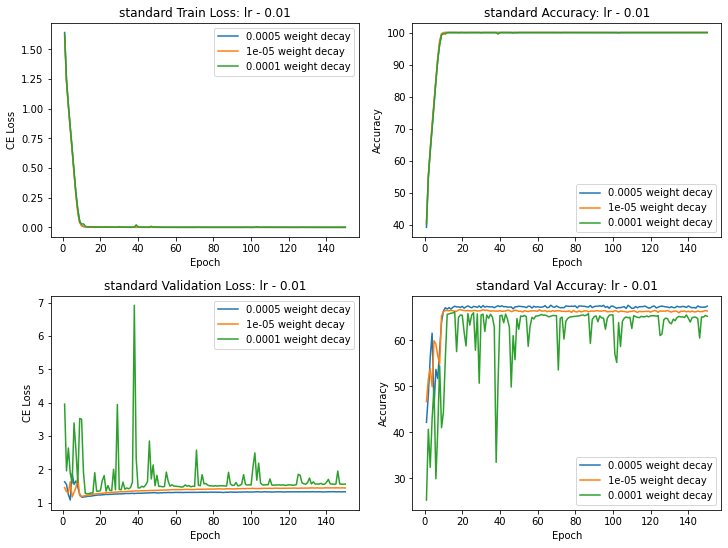

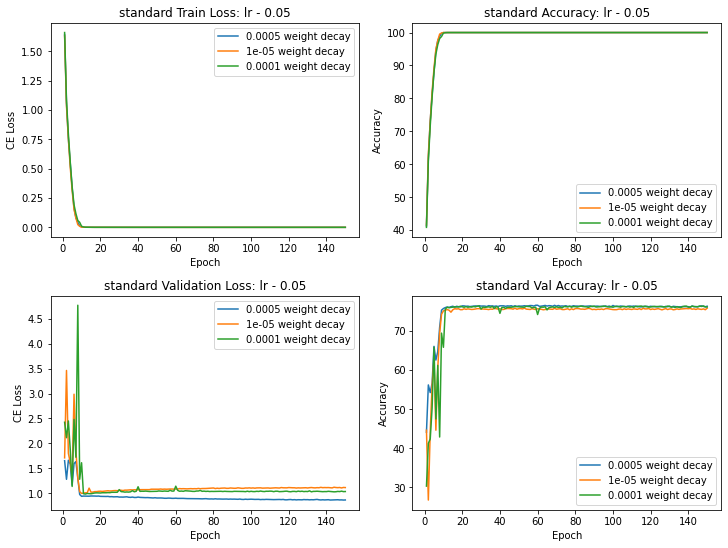

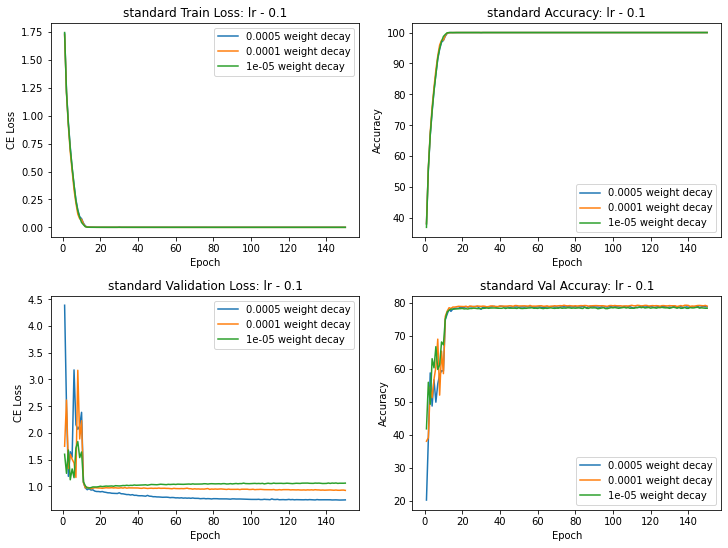

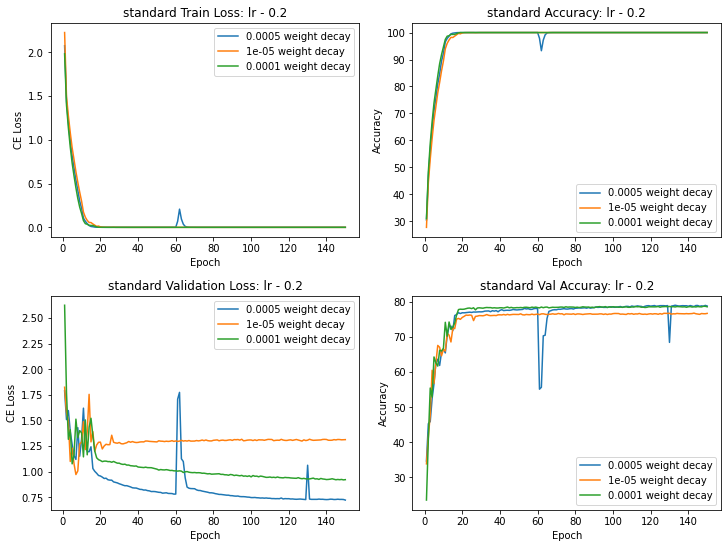

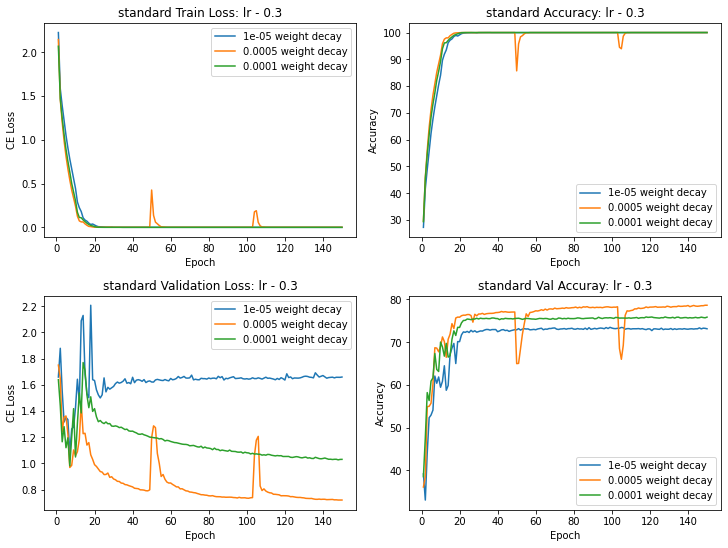

In [186]:
plot(base_logs, base_metadata, 'base')
plot(trunc_logs, trunc_metadata, 'trunc')
plot(standard_logs, standard_metadata, 'standard')

In [190]:
plt.figure(figsize=(10, 20))

# iterate over learning rates
def filter_(metadata, unseen, test, trunc_train, train_base):
    # iterate over learning rates
    for i, lr in enumerate(metadata.lr.unique()): 
        # experiment ids
        exp_ids = metadata[metadata.lr.isin([lr])].exp_id

        # use .apply() to find exp id for every experiment                       
        unseen['lr'] =  unseen.apply(lambda row: metadata[metadata.exp_id == row['exp_id']]['lr'], axis=1)
        test['lr'] = test.apply(lambda row: metadata[metadata.exp_id == row['exp_id']]['lr'], axis=1)
        trunc_train['lr'] = trunc_train.apply(lambda row: metadata[metadata.exp_id == row.exp_id]['lr'], axis=1)
        train_base['lr'] = train_base.apply(lambda row: metadata[metadata.exp_id == row.exp_id]['lr'], axis=1)
        
    for i, weight_decay in enumerate(metadata.weight_decay.unique()): 
        # experiment ids
        exp_ids = metadata[metadata.weight_decay.isin([weight_decay])].exp_id

        # use .apply() to find exp id for every experiment                       
        unseen['weight_decay'] =  unseen.apply(lambda row: metadata[metadata.exp_id == row['exp_id']]['weight_decay'], axis=1)
        test['weight_decay'] = test.apply(lambda row: metadata[metadata.exp_id == row['exp_id']]['weight_decay'], axis=1)
        trunc_train['weight_decay'] = trunc_train.apply(lambda row: metadata[metadata.exp_id == row.exp_id]['weight_decay'], axis=1)
        train_base['weight_decay'] = train_base.apply(lambda row: metadata[metadata.exp_id == row.exp_id]['weight_decay'], axis=1)
    return unseen, test, trunc_train, train_base


unseen_, test_, trunc_train_, train_base_ = filter_(base_metadata, unseen, test, trunc_train, train_base)
trunc_unseen_, trunc_test_, trunc_trunc_train_, trunc_train_base_ = filter_(trunc_metadata, trunc_unseen, trunc_test, trunc_trunc_train, trunc_train_base)
standard_unseen_, standard_test_, standard_trunc_train_, standard_train_base_ = filter_(standard_metadata, standard_unseen, standard_test, standard_trunc_train, standard_train_base)

    
# plt.subplot(4, 1, 1)
# sns.lineplot(x='lr', y='test_prec1', data=unseen_, label='base')
# sns.lineplot(x='lr', y='test_prec1', data=trunc_unseen_, label='trunc')
# sns.lineplot(x='lr', y='test_prec1', data=standard_unseen_, label='standard')
# plt.title('Unseen')
# plt.xlabel('Learning Rate')
# plt.ylabel('Accuracy')


# plt.subplot(4, 1, 2)
# sns.lineplot(x='lr', y='test_prec1', data=test_, label='base')
# sns.lineplot(x='lr', y='test_prec1', data=trunc_test_, label='trunc')
# sns.lineplot(x='lr', y='test_prec1', data=standard_test_, label='standard')
# plt.title('Test')
# plt.xlabel('Learning Rate')
# plt.ylabel('Accuracy')

# plt.subplot(4, 1, 3)
# sns.lineplot(x='lr', y='test_prec1', data=trunc_train_, label='base')
# sns.lineplot(x='lr', y='test_prec1', data=trunc_trunc_train_, label='trunc')
# sns.lineplot(x='lr', y='test_prec1', data=standard_trunc_train_, label='standard')
# plt.title('Truncated Training Set')
# plt.xlabel('Learning Rate')
# plt.ylabel('Accuracy')

# plt.subplot(4, 1, 4)
# sns.lineplot(x='lr', y='test_prec1', data=train_base_, label='base')
# sns.lineplot(x='lr', y='test_prec1', data=trunc_train_base_, label='trunc')
# sns.lineplot(x='lr', y='test_prec1', data=standard_train_base_, label='standard')
# plt.title('Base Classifier Training Set')
# plt.xlabel('Learning Rate')
# plt.ylabel('Accuracy')

<Figure size 720x1440 with 0 Axes>

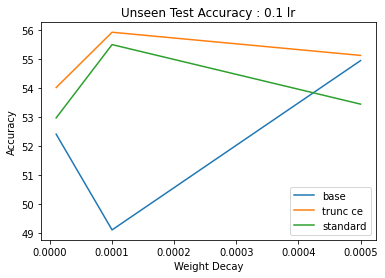

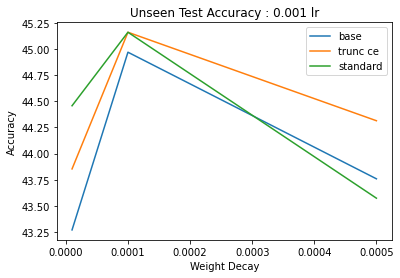

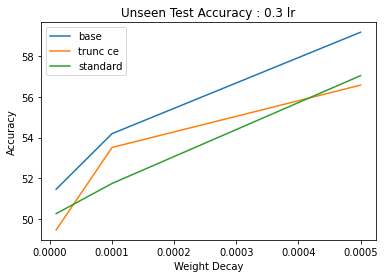

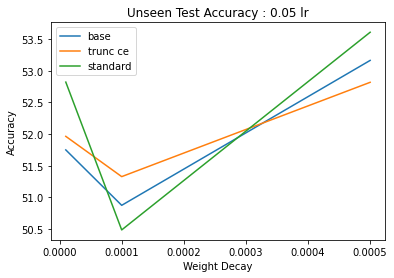

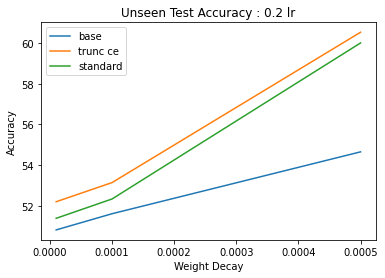

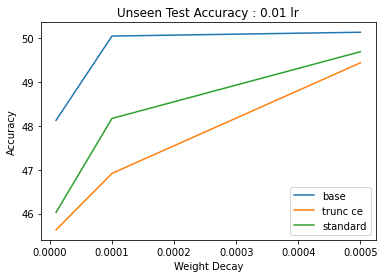

In [211]:
for i, lr in enumerate(unseen_.lr.unique()): 
    logs_ = unseen_[unseen_.lr == lr].sort_values(by=['weight_decay'])
    trunc_logs_ = trunc_unseen_[trunc_unseen_.lr == lr].sort_values(by=['weight_decay'])
    standard_logs_ = standard_unseen_[standard_unseen_.lr == lr].sort_values(by=['weight_decay'])
    plt.plot(logs_.weight_decay, logs_.test_prec1, label='base')
    plt.plot(trunc_logs_.weight_decay, trunc_logs_.test_prec1, label='trunc ce')
    plt.plot(standard_logs_.weight_decay, standard_logs_.test_prec1, label='standard')
    plt.xlabel('Weight Decay')
    plt.ylabel('Accuracy')
    plt.title('Unseen Test Accuracy : {} lr'.format(lr))
    plt.legend()
    plt.show()

In [115]:
ax

array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)